# Road Lane Line Recognition

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


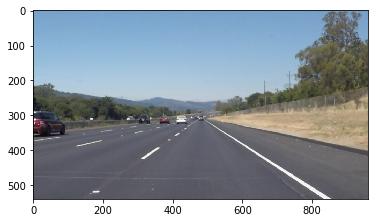

In [4]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

In [14]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    
    #filing pixels inside the polygon
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #only return mask pixels
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness = 2):
    
    y_max = img.shape[0]
    y_min = img.shape[0]
    
    positive_slope_points, negetive_slope_points = [], []
    
    positive_intercepts, negetive_intercepts = [], []
    
    left_line_x, left_line_y = [], []
    right_line_x, right_line_y = [], []
    
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            
            try:
                current_slope = (y2 - y1) / (x2 - x1)
                
            except ZeroDivisionError:
                current_slope = -np.inf
                
            
            #Left lane line
            if current_slope < 0.0 and current_slope > -np.inf:
                
                negetive_slope_points.append(current_slope)
                
                left_line_x.append(x1)
                left_line_x.append(x2)
                left_line_y.append(y1)
                left_line_y.append(y2)
                
                negetive_intercepts.append(y1 - current_slope * x1)
                
            
            #Right lane line:
            if current_slope > 0.0 and current_slope < -np.inf:
                
                positive_slope_points.append(current_slope)
                
                right_line_x.append(x1)
                right_line_x.append(x2)
                right_line_y.append(y1)
                right_line_y.append(y2)
                
                positive_intercepts.append(y1 - current_slope * x1)
                
            
            y_min = min(y_min, y1, y2)
            
        
    y_min += 15
    
    if len(negetive_slope_points) > 0 and len(left_line_x) > 0 and len(left_line_y) > 0:
        
        average_negetive_slope = sum(negetive_slope_points) / len(negetive_slope_points)
        average_left_line_x = sum(left_line_x) / len(left_line_x)
        average_left_line_y = sum(left_line_y) / len(left_line_y)
        intercept = sum(negetive_intercepts) / len(negetive_intercepts)
        
        x_min = int((y_min - intercept) / (average_negetive_slope))
        x_max = int((y_max - intercept) / (average_negetive_slope))
        
        cv2.line(img, (x_min, y_min), (x_max, y_max), color = [255, 0, 0], thickness = 12)
        
        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    draw_lines(line_img, lines)
    return line_img



def weighted_img(img, initial_img, alpha = 0.8, beta = 1., gama = 0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gama)

In [15]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'test.jpg',
 'whiteCarLaneSwitch.jpg']

In [16]:
# The pipeline for drawing lane lines
def pipeline(image):
    
    # 1. print out some details and convert to Grayscale the image
    image_height = image.shape[0]
    image_width = image.shape[1]
    
     
    grayscale_image = grayscale(image)
    
    # 2. Define a kernel size for Gaussian Smoothing / blurring
    kernel_size = 3
    smooth_blurred_image = gaussian_blur(grayscale_image, kernel_size)
    
    # 3. Define our parameters for Canny Edge Detection and run it
    low_threshold = 75
    high_threshold = 150
    edges = canny(smooth_blurred_image, low_threshold, high_threshold)
    
    # 4. Mask edges using cv2.fillPoly() to get refion of interest
        
    vertices = np.array([[[(75, image_height), 
                           (image_width/2 - 40, image_height/2 + 40), 
                           (image_width/2 + 40, image_height/2 + 40), 
                          (image_width-75, image_height)]]], 
                           dtype=np.int32)
    
    region = region_of_interest(edges, vertices)
    
    # 5. Define Hough transform parameters
    # and run it on masked_edge-detected image
    
    rho = 2
    theta = np.pi/180
    threshold = 100
    min_line_length = 25
    max_line_gap = 25
    
    # line_image = np.copy(image)*0 
    
    hough_image = hough_lines(region, rho, theta, threshold, 
                              min_line_length, max_line_gap)
    
    lines_edges = weighted_img(hough_image, image)
    return lines_edges

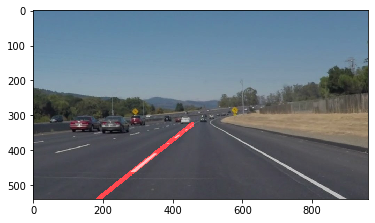

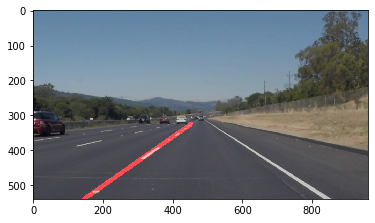

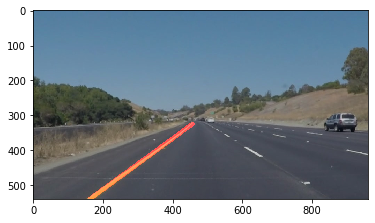

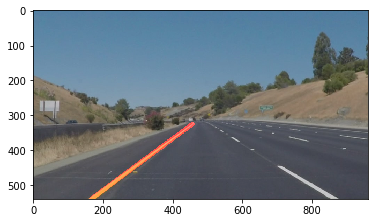

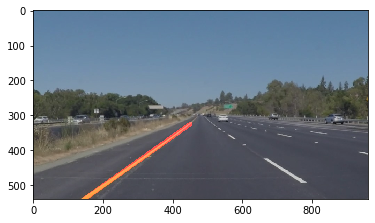

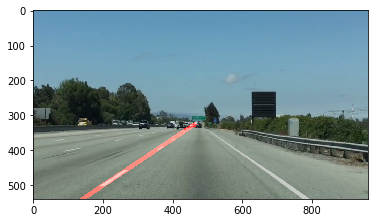

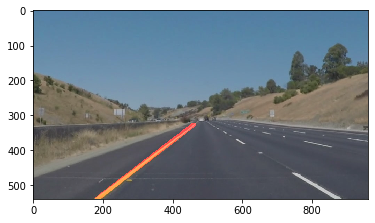

In [17]:
# let's test our pipeline
for test_image in os.listdir('test_images/'):
    image = mpimg.imread('test_images/' + test_image)
    plt.imshow(pipeline(image))
    plt.show()

In [20]:
def process_image(image):
    return pipeline(image)

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'white.mp4'
clip1 = VideoFileClip("challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 36.9 s
